In [25]:
import os
import glob
import functools
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import data_io
import u_net

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

# tf.enable_eager_execution()
tf.__version__

'2.0.0-alpha0'

# Set up

In [26]:
common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67'

img_dir = os.path.join(common_root, 'images')
mask_dir = os.path.join(common_root, 'masks')

# max_intensity = 4095.
batch_size = 5
# epochs = 5

In [6]:
x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-2.png'))) # nucleus images
y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_nucleus.jpeg'))) # nucleus masks     


# Split into training and validation
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = \
    train_test_split(x_train_fnames, y_train_fnames, test_size=0.2, random_state=43)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 388
Number of validation samples: 98


In [7]:
idx = np.random.choice(num_train_data)
print(os.path.basename(x_train_fnames[idx]))
print(os.path.basename(y_train_fnames[idx]))

CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F5_0008-2.png
CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F5_0008_nucleus.jpeg


# Build the input pipeline

### Get images and masks from path names

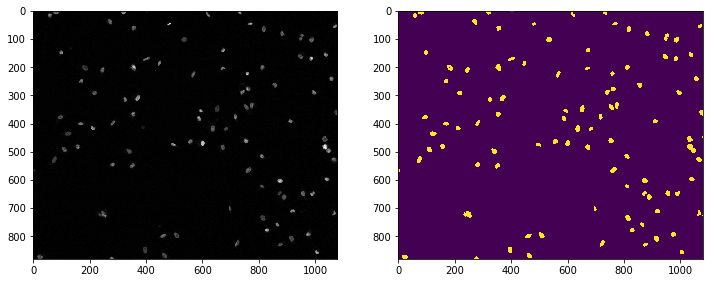

In [9]:
idx = np.random.choice(num_train_data)
img, mask = data_io._get_image_from_path(x_train_fnames[idx], y_train_fnames[idx])

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

In [10]:
print(img.shape)
print(img.dtype)
print(mask.shape)
print(img.numpy().max())

(880, 1080, 1)
<dtype: 'uint8'>
(880, 1080, 1)
251


### Test the input pipeline

In [18]:
tmp_ds = data_io.get_dataset(x_train_fnames, y_train_fnames)

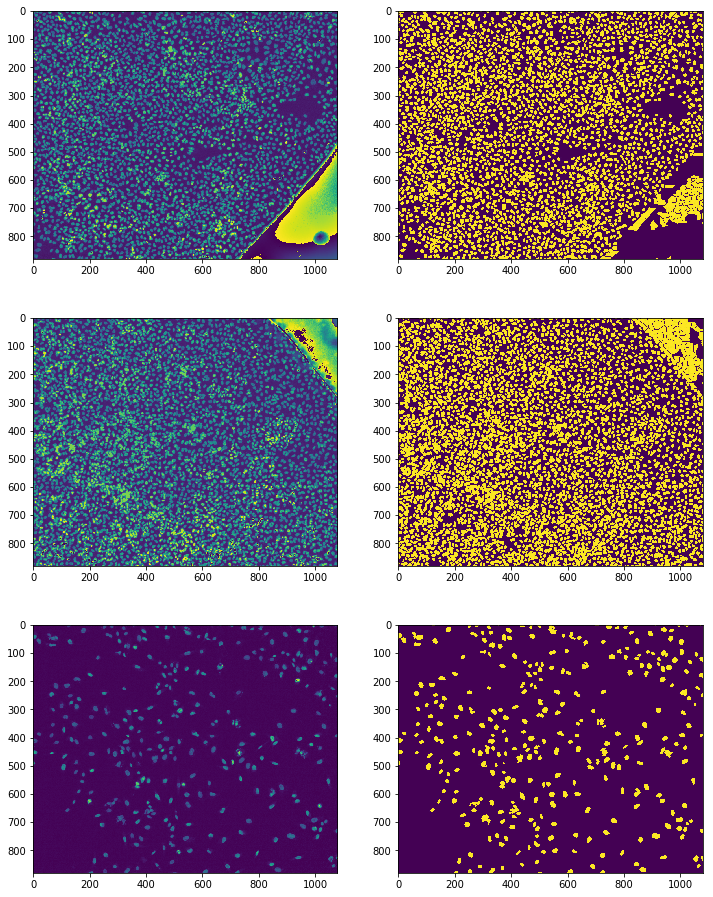

In [21]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.shuffle(num_train_data).take(3)):
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,0])
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,0])
plt.show()

### Configure training and validation datasets

In [23]:
# training data
train_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(data_io._augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512]
}
val_preproc_fn = functools.partial(data_io._augment, **val_cfg)

In [27]:
train_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, preproc_fn=tr_preproc_fn, 
                       shuffle=True, batch_size=batch_size)
val_ds = data_io.get_dataset(x_val_fnames, y_val_fnames, preproc_fn=val_preproc_fn, 
                     shuffle=False, batch_size=batch_size)

# Build the model

In [28]:
model = u_net.get_model(num_filters_list=[32, 64, 128, 256, 512])

# plt.figure(figsize=(12,16))
# for i, (img, mask) in enumerate(train_ds.take(1)):
#     y_pred = model(img)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])
#     plt.subplot(1,3,2)
#     plt.imshow(mask[0,:,:,0])
#     plt.subplot(1,3,3)
#     plt.imshow(y_pred[0,:,:,0])
# plt.show()

## Train the model

In [ ]:
save_path = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/weights-{epoch:04d}.ckpt'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, monitor='val_dice_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
history = model.fit(train_ds, epochs=20, 
                    steps_per_epoch=int(np.ceil(num_train_data / batch_size)),
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_data / batch_size)),
                    callbacks=[cp])

### Plot training process

In [ ]:
tr_process = pd.DataFrame.from_dict(history.history)
tr_process['epoch'] = np.array(range(1, epochs+1))

In [ ]:
tr_process.plot(x='epoch', y=['loss', 'dice_loss'])

# Visualize performance

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(val_ds.shuffle(num_val_data).take(1)):
    idx = 3
    print(img.shape)
    y_pred = model(img)
    
    plt.subplot(1,3,1)
    plt.imshow(img[idx,:,:,0], cmap='gray')
    
    plt.subplot(1,3,2)
    plt.imshow(mask[idx,:,:,0], cmap='gray')
    
    plt.subplot(1,3,3)
    plt.imshow(y_pred[idx,:,:,0], cmap='gray')